In [1]:
# -----------------------------
# Imports & setup
# -----------------------------
import os, re, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy, pdfplumber, docx, torch
from difflib import SequenceMatcher
from tqdm import tqdm

from sentence_transformers import SentenceTransformer, util
from sentence_transformers import CrossEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold, GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, mean_absolute_error,
    ConfusionMatrixDisplay, roc_auc_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, plot_importance
import shap

C:\Users\rashf\anaconda3\envs\resume-nlp\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\rashf\anaconda3\envs\resume-nlp\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\rashf\anaconda3\envs\resume-nlp\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\rashf\anaconda3\envs\resume-nlp\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
# Jupyter plotting prefs
# makes matplotlib figures look sharper in notebooks
plt.rcParams["figure.dpi"] = 120

In [3]:
# -----------------------------
# Constants / mappings
# -----------------------------

# (we embed these example titles later to classify any free-text title into one of these families)
canonical_categories = {
    "HR": ["hr manager", "recruiter", "talent acquisition"],
    "DESIGNER": ["graphic designer", "product designer", "ux designer"],
    "INFORMATION-TECHNOLOGY": ["software engineer", "backend developer", "full stack developer"],
    "DATA-SCIENCE": ["data scientist", "data analyst", "ml engineer"],  # ADDED
    "TEACHER": ["math teacher", "science instructor", "school teacher"],
    "ADVOCATE": ["lawyer", "legal counsel", "attorney"],
    "BUSINESS-DEVELOPMENT": ["business development executive", "account manager", "growth strategist"],
    "HEALTHCARE": ["nurse", "medical assistant", "healthcare practitioner"],
    "FITNESS": ["fitness trainer", "personal trainer", "gym coach"],
    "AGRICULTURE": ["farm manager", "agriculture officer", "crop specialist"],
    "BPO": ["call center agent", "customer support", "technical support representative"],
    "SALES": ["sales representative", "sales manager", "retail associate"],
    "CONSULTANT": ["business consultant", "strategy advisor", "management consultant"],
    "DIGITAL-MEDIA": ["social media manager", "content creator", "digital marketing specialist"],
    "AUTOMOBILE": ["automotive technician", "mechanic", "car service advisor"],
    "CHEF": ["chef", "line cook", "culinary expert"],
    "FINANCE": ["financial analyst", "investment associate", "banker"],
    "APPAREL": ["fashion designer", "retail buyer", "apparel merchandiser"],
    "ENGINEERING": ["mechanical engineer", "electrical engineer", "civil engineer"],
    "ACCOUNTANT": ["accountant", "auditor", "bookkeeper"],
    "CONSTRUCTION": ["construction supervisor", "civil site engineer", "project foreman"],
    "PUBLIC-RELATIONS": ["public relations officer", "communications specialist", "media coordinator"],
    "BANKING": ["bank teller", "relationship manager", "loan officer"],
    "ARTS": ["fine artist", "illustrator", "art teacher"],
    "AVIATION": ["pilot", "air traffic controller", "cabin crew"],
    "MARKETING": ["marketing specialist", "seo specialist", "brand manager"],  
    "HOSPITALITY": ["hotel manager", "front desk agent", "guest services"]   
}

# “close enough” neighbors between families - used to allow pairing even if resume and JD categories aren't identical)
related_fields = {
    "INFORMATION-TECHNOLOGY": ["ENGINEERING", "DATA-SCIENCE"],
    "DATA-SCIENCE": ["INFORMATION-TECHNOLOGY", "ENGINEERING"],
    "ENGINEERING": ["INFORMATION-TECHNOLOGY", "DATA-SCIENCE"],
    "SALES": ["MARKETING", "BPO", "BUSINESS-DEVELOPMENT"],
    "BUSINESS-DEVELOPMENT": ["SALES", "MARKETING", "CONSULTANT"],
    "MARKETING": ["SALES", "DIGITAL-MEDIA"],
    "BPO": ["SALES"],
    "ACCOUNTANT": ["FINANCE", "BANKING"],
    "FINANCE": ["ACCOUNTANT", "BANKING"],
    "BANKING": ["FINANCE", "ACCOUNTANT"],
    "HEALTHCARE": ["FITNESS"],
    "FITNESS": ["HEALTHCARE"],
    "CHEF": ["HOSPITALITY"],
    "HOSPITALITY": ["CHEF"],
    "CONSULTANT": ["BUSINESS-DEVELOPMENT", "PUBLIC-RELATIONS"],
    "PUBLIC-RELATIONS": ["CONSULTANT", "DIGITAL-MEDIA"],
    "DIGITAL-MEDIA": ["PUBLIC-RELATIONS", "MARKETING"],
    "CONSTRUCTION": ["ENGINEERING"],
    "AUTOMOBILE": ["ENGINEERING"],
    "AVIATION": ["ENGINEERING"],
    "TEACHER": ["HR"],
    "HR": ["TEACHER", "CONSULTANT"],
    "APPAREL": ["DESIGNER"],
    "DESIGNER": ["APPAREL", "ARTS"],
    "ARTS": ["DESIGNER", "TEACHER"],
    "ADVOCATE": ["PUBLIC-RELATIONS"] 
}

# keyword hints per sector 
domain_keywords = {
    "INFORMATION-TECHNOLOGY": ["software", "developer", "backend", "cloud", "sql", "api", "python"],
    "DATA-SCIENCE": ["data", "model", "regression", "machine learning", "pandas", "statistics"],
    "ENGINEERING": ["mechanical", "civil", "electrical", "autocad", "maintenance"],
    "SALES": ["sales", "deal", "client", "upselling"],
    "BUSINESS-DEVELOPMENT": ["partnership", "growth", "b2b", "strategy"],
    "MARKETING": ["campaign", "social media", "advertising", "seo"],
    "HEALTHCARE": ["patient", "hospital", "clinical", "treatment", "medical"],
    "FITNESS": ["fitness", "workout", "trainer"],
    "HOSPITALITY": ["hospitality", "guest", "check-in", "hotel"],
    "TEACHER": ["teacher", "lesson", "curriculum", "student"],
    "DESIGNER": ["ui", "ux", "figma", "design"],
    "ARTS": ["concert", "festival", "stage", "performance"],
    "ACCOUNTANT": ["ledger", "tax", "audit", "bookkeeping"],
    "ADVOCATE": ["legal", "attorney", "court"],
    "AVIATION": ["pilot", "aircraft", "airport"],
    "CHEF": ["kitchen", "chef", "cooking"]
}


In [4]:
# Checking that every category used in related_fields exists in canonical vocab 
_all_known = set(canonical_categories) | set(domain_keywords)
_unknown_in_related = {k: [x for x in v if x not in _all_known] for k, v in related_fields.items()}
_unknown_in_related = {k: v for k, v in _unknown_in_related.items() if v}
assert not _unknown_in_related, f"related_fields has unknown categories: {_unknown_in_related}"


In [5]:
# -----------------------------
# Utility funcs
# -----------------------------
def read_resume_file(file_path):
    if file_path.endswith(".pdf"):
        with pdfplumber.open(file_path) as pdf:
            # join text from all pages; skip pages with no extractable text
            return "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())
    elif file_path.endswith(".docx"):
        doc = docx.Document(file_path)
         # concat paragraph texts
        return "\n".join([para.text for para in doc.paragraphs])
    elif file_path.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    else:
        # only support these formats in the app
        raise ValueError("Unsupported file type. Please upload PDF, DOCX, or TXT.")

def requires_degree(text):
    keywords = ['bachelor', 'b.sc', 'm.sc', 'master', 'mba', 'phd', 'md', 'degree']
    if not isinstance(text, str): return 0
    return int(any(k in text.lower() for k in keywords))

def mentions_experience(text):
    if not isinstance(text, str): return 0
    t = text.lower()
    return int(('experience' in t) or ('worked at' in t) or ('responsible for' in t))

# Checking for sections like: skills, education, experience
def has_section(text, keyword):
    if not isinstance(text, str): return 0
    return int(keyword.lower() in text.lower())

In [6]:
# ------------- NLTK setup -------------

# fixed local path for NLTK data 
nltk_path = os.path.expanduser("C:/Users/rashf/nltk_data")
os.makedirs(nltk_path, exist_ok=True)

# Add path for lookup
if nltk_path not in nltk.data.path:
    nltk.data.path.append(nltk_path)

# Download only if missing
def _ensure_nltk_resource(resource, subpath):
    try:
        nltk.data.find(subpath)
    except LookupError:
        nltk.download(resource, download_dir=nltk_path)

_ensure_nltk_resource('punkt', 'tokenizers/punkt')
_ensure_nltk_resource('stopwords', 'corpora/stopwords')
_ensure_nltk_resource('wordnet', 'corpora/wordnet')

# 'punkt_tab' is not required; keeping it optional and silent
try:
    _ensure_nltk_resource('punkt_tab', 'tokenizers/punkt_tab')
except Exception:
    pass

# Checking if GPU is being used
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not available — still using CPU")


CUDA available: True
Using device: NVIDIA GeForce RTX 4070 Laptop GPU


[nltk_data] Downloading package wordnet to C:/Users/rashf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# -----------------------------
# 2. LOAD & CLEAN DATA
# -----------------------------

# load the resume dataset and the job dataset
resume_df = pd.read_csv("Resume.csv")
job_df = pd.read_csv("training_data.csv")

# drop unused columns  
resume_df.drop(columns=[c for c in ['Resume_html'] if c in resume_df.columns], inplace=True)
job_df.drop(columns=[c for c in ['model_response'] if c in job_df.columns], inplace=True)

# Resume cleaning
# keep rows that actually have text and a category label
resume_df.dropna(subset=['Resume_str', 'Category'], inplace=True)
# remove HTML / templated junk resumes
resume_df = resume_df[~resume_df['Resume_str'].str.contains('<div|</div|<!--|font|class=|<!DOCTYPE|\\{|\\}|\\[', na=False)]
# trim whitespace
resume_df['Resume_str'] = resume_df['Resume_str'].str.strip()
# require a minimum size so we don’t train on short snippets
resume_df = resume_df[resume_df['Resume_str'].str.len() > 500]
resume_df = resume_df[resume_df['Resume_str'].str.split().str.len() > 100]
# remove duplicate resumes
resume_df.drop_duplicates(subset=['Resume_str'], inplace=True)
# normalize category labels
resume_df['Category'] = resume_df['Category'].str.upper().str.strip()

# Job cleaning
print("Initial job count:", job_df.shape)
# must have both description and title
job_df.dropna(subset=['job_description', 'position_title'], inplace=True)
print("Jobs after removing NaNs:", job_df.shape)
# require a minimum size so we don’t train on short snippets
job_df = job_df[job_df['job_description'].str.len() > 50]
print("Jobs after length filter (>50):", job_df.shape)
# remove duplicate JD
job_df.drop_duplicates(subset=['job_description'], inplace=True)
# trim whitespace
job_df['job_description'] = job_df['job_description'].str.strip()
job_df['position_title'] = job_df['position_title'].str.strip()


Initial job count: (853, 4)
Jobs after removing NaNs: (853, 4)
Jobs after length filter (>50): (849, 4)


In [8]:
# -----------------------------
# 3. CLEAN & EXTRACT TEXT
# -----------------------------

# set up stopwords + lemmatizer 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# remove all HTML, URLs, keep all letters lowercase 
def clean_text(text):
    if not isinstance(text, str): return ""
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

# Simply collect text under each section: 'education', 'experience', and 'skills' headings
def extract_sections(text):
    text = (text or "").lower()
    sections = {"education": "", "experience": "", "skills": ""}
    current = None
    for line in text.splitlines():
        if "education" in line:
            current = "education"
        elif "experience" in line or "worked at" in line:
            current = "experience"
        elif "skill" in line:
            current = "skills"
        elif current:
            sections[current] += " " + line.strip()
    return sections

# extract rough sections from resumes
resume_sections = resume_df['Resume_str'].apply(extract_sections)
# build cleaned text that is just 'education', 'experience', and 'skills'
resume_df['cleaned_resume'] = resume_sections.apply(lambda x: x['education'] + " " + x['experience'] + " " + x['skills'])
# keep only resumes with enough content after sectioning
resume_df = resume_df[resume_df['cleaned_resume'].str.split().str.len() > 50]


In [9]:
# ------------- 4. EXTRACT JOB REQUIREMENTS (pre-filter text) -------------

# keep lines that look like requirement/skills headers, otherwise fall back to the full text.
def extract_job_reqs(text):
   
    if not isinstance(text, str):
        return ""
    t = text or ""
    lines = t.splitlines()
    # keywords that show we are in the requirements/skills part
    sections = [
        'requirement', 'responsibil', 'qualif', 'expect',
        'must have', 'should have', 'what you’ll do', 'what you will do',
        'your role', 'skills', 'key skills'
    ]
    relevant = []
    for ln in lines:
        low = (ln or "").lower()
        if any(s in low for s in sections):
            relevant.append(ln.strip())
    
    if len(relevant) < 3:
        return t
    return " ".join(relevant)



# apply the JD prefilter and then fully clean that text
job_df['requirements'] = job_df['job_description'].apply(extract_job_reqs)
job_df['cleaned_reqs'] = job_df['requirements'].apply(clean_text)
# keep only JDs with enough content after cleaning
job_df = job_df[job_df['cleaned_reqs'].str.split().str.len() > 50]
print("Final usable job count:", len(job_df))

Final usable job count: 579


In [10]:
# -----------------------------
# 5. STRUCTURED EXTRACTORS
# -----------------------------

# Check for and return a specific set of soft skills by regex 
def soft_skill_patterns(text):
    patterns = {
        "communication": [r"\bcommunication\b", r"\bcommunicat(e|or|ing)\b"],
        "teamwork": [r"\bteamwork\b", r"led a team", r"part of a team"],
        "leadership": [r"\bleadership\b", r"\bled\b", r"\bmanaged team\b"],
        "adaptability": [r"\badapt\b", r"\bflexible\b", r"\bquick learner\b"],
        "problem-solving": [r"\bproblem[- ]?solving\b", r"\bsolve problems?\b"],
    }
    matched = []
    for skill, regs in patterns.items():
        for pattern in regs:
            if re.search(pattern, (text or "").lower()):
                matched.append(skill)
                break
    return matched


In [11]:
# === Unified tools & aliases ===

# Normalize different spellings to a single tool name.
TOOL_ALIASES = {
    'sklearn': 'scikit-learn', 'scikit learn': 'scikit-learn',
    'tf': 'tensorflow', 'torch': 'pytorch', 'ms excel': 'excel',
    'powerbi': 'power bi', 'power-bi': 'power bi', 'g-cloud': 'gcp',
    'microsoft excel':'excel', 'pivot tables':'excel', 'vlookup':'excel'
}

# Main list of tools.
TOOL_LIST = [
    'python','sql','r','excel','pandas','numpy','scikit-learn','tensorflow','pytorch','keras',
    'spark','hadoop','tableau','power bi','aws','azure','gcp','docker','kubernetes','spss','sas',
    'vlookup','pivot tables','microsoft excel'
]

# Searching for canonical names and raw alias keys together
TOOL_SEARCH_TERMS = sorted(set(TOOL_LIST + list(TOOL_ALIASES.keys())))
# Link the main tool name with the alias
def normalize_tool(token: str) -> str:
    t = token.lower().strip()
    t = TOOL_ALIASES.get(t, t)
    return t


In [12]:
# Common bachelor/master variants and avoid false positives
MASTER_TERMS = [
    r'm\.?\s*sc', r'msc', r'mtech', r'm\.?\s*eng', r'meng',
    r'mba', r'mphil', r'm\.?\s*phil', r'med', r'm\.?\s*ed',
    r'mfin', r'm\.?\s*fin', r'macc', r'm\.?\s*acc', r'mca', r'm\.?\s*ca'
]

BACHELOR_TERMS = [
    r'b\.?\s*sc', r'bsc', r'btech', r'b\.?\s*eng', r'beng', r'b\.?\s*e', r'be',
    r'bba', r'b\.?\s*ba', r'bcom', r'b\.?\s*com', r'bca', r'b\.?\s*ca',
    r'mbbs'  # treat MBBS as bachelor-level
]

# Require context for bare "ms"/"bs", only accept "ms"/"bs" if followed by "degree" or "in"
MS_CONTEXT = r'\bms\b(?=(?:[^a-zA-Z]{0,10})(?:degree\b|\bin\b))'
BS_CONTEXT = r'\bbs\b(?=(?:[^a-zA-Z]{0,10})(?:degree\b|\bin\b))'

# Compile PhD > Master > Bachelor
DEGREE_PATTERNS = [
    re.compile(r'\b(ph\.?\s*d|doctorate|dphil)\b'),  
    re.compile(r'(' + '|'.join(MASTER_TERMS + [MS_CONTEXT]) + r'|master[’\'s]?)\b'),
    re.compile(r'(' + '|'.join(BACHELOR_TERMS + [BS_CONTEXT]) + r'|bachelor[’\'s]?)\b')
]

# Return one of "phd","master","bachelor", None, based on regex hits.
def detect_degree(text_lower):
    t = text_lower.lower() if isinstance(text_lower, str) else ''
    if DEGREE_PATTERNS[0].search(t): return "phd"
    if DEGREE_PATTERNS[1].search(t): return "master"
    if DEGREE_PATTERNS[2].search(t): return "bachelor"
    return None


In [13]:
def extract_job_requirements(text):
    # Default structure that will be filled from the JD 
    reqs = {
        "degree": None,
        "experience_years": 0,
        "tools": [],
        "soft_skills": []
    }
    if not isinstance(text, str):
        return reqs

    text = text.lower()

    # Take requirement related paragraphs, fallback to full JD if not found
    pattern = re.compile(r"(requirement[s]?|responsibilit(?:y|ies)|qualification[s]?|skills|expectation[s]?|must have|what you’ll do|what you will do)", re.IGNORECASE)
    matches = pattern.finditer(text)
    relevant_text = ""
    for match in matches:
        start = match.start()
        # Taking around 1000 characters after each matched section
        paragraph = text[start:start+1000]
        relevant_text += " " + paragraph
    if not relevant_text.strip():
        relevant_text = text #fallback

    # Degree (phd/master/bachelor/None)
    reqs["degree"] = detect_degree(relevant_text)

    # Experience years
    yrs = []
    # numeric ranges: "2-4 years"
    for a, b in re.findall(r'(\d+)\s*(?:-|–|to)\s*(\d+)\s*(?:years?|yrs?)', relevant_text):
        yrs.extend([a, b])
    # numeric minimums: "minimum 2 years"
    yrs += re.findall(r'(?:at\s*least|minimum|min\.?|>=)\s*(\d+)\s*(?:years?|yrs?)', relevant_text)
    # numeric singles: "3+ years"
    yrs += re.findall(r'(\d+)\s*\+?\s*(?:years?|yrs?)', relevant_text)

    # worded numbers: "two years"
    word_map = {
        'one':1,'two':2,'three':3,'four':4,'five':5,
        'six':6,'seven':7,'eight':8,'nine':9,'ten':10
    }
    for w in re.findall(r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\s*\+?\s*(?:years?|yrs?)', relevant_text):
        yrs.append(str(word_map.get(w, 0)))

    yrs = [int(n) for n in yrs if str(n).isdigit()]
    reqs["experience_years"] = max(yrs) if yrs else 0


    # Tools, both canonical names and aliases
    reqs["tools"] = []
    for term in TOOL_SEARCH_TERMS:
        patt = rf"(?<!\w){re.escape(term)}(?!\w)"
        if re.search(patt, relevant_text):
            reqs["tools"].append(normalize_tool(term))
    reqs["tools"] = sorted(set(reqs["tools"]))

    # Soft skills
    reqs["soft_skills"] = soft_skill_patterns(relevant_text)
    return reqs

In [14]:
def extract_resume_profile(text):
    # Default structure that will be filled from the resume
    profile = {
        "degree": None,
        "experience_years": 0,
        "tools": [],
        "soft_skills": []
    }
    if not isinstance(text, str):
        return profile
    text = text.lower()

    # Degree 
    profile["degree"] = detect_degree(text)

    # Experience years, date wise
    date_ranges = re.findall(r'(\d{2}/\d{4})\s*(to|-)\s*(\d{2}/\d{4}|current|present)', text)
    total_months = 0
    for start, _, end in date_ranges:
        try:
            start_dt = pd.to_datetime(start, format='%m/%Y', errors='coerce')
            end_dt = pd.to_datetime(end if end not in ['current', 'present'] else pd.Timestamp.now(), format='%m/%Y', errors='coerce')
            if pd.notna(start_dt) and pd.notna(end_dt):
                total_months += (end_dt.year - start_dt.year) * 12 + (end_dt.month - start_dt.month)
        except:
            continue
    years_from_dates = round(total_months / 12, 1)

    # Fallback: if dates are not present 
    yrs = []
    yrs += re.findall(r'(\d+)\s*(?:-|–|to)\s*(\d+)\s*(?:years?|yrs?)', text)
    yrs_single = re.findall(r'(?:at\s*least|minimum|min\.?|>=)?\s*(\d+)\s*\+?\s*(?:years?|yrs?)', text)
    # Flatten ranges
    yr_nums = []
    for tup in yrs:
        for v in tup:
            if v.isdigit(): yr_nums.append(int(v))
    yr_nums += [int(x) for x in yrs_single if x.isdigit()]
    
    years_from_text = max(yr_nums) if yr_nums else 0
    profile["experience_years"] = years_from_dates if years_from_dates > 0 else years_from_text


    # Tools both canonical names and aliases
    profile["tools"] = []
    for term in TOOL_SEARCH_TERMS:
        patt = rf"(?<!\w){re.escape(term)}(?!\w)"
        if re.search(patt, text):
            profile["tools"].append(normalize_tool(term))
    profile["tools"] = sorted(set(profile["tools"]))


    # Soft skills
    profile["soft_skills"] = soft_skill_patterns(text)
    return profile


In [15]:
# -----------------------------
# 6. JOB / TITLE CATEGORY, SBERT
# -----------------------------

# load SpaCy transformer pipeline 
nlp = spacy.load("en_core_web_trf")
# sentence-transformers model for semantic embeddings
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# pre-compute embeddings for example titles per canonical category
cat_embeddings = {
    cat: sbert_model.encode(titles, convert_to_tensor=True)
    for cat, titles in canonical_categories.items()
}

def classify_title(title):
    if not isinstance(title, str): return None
    title_emb = sbert_model.encode(title, convert_to_tensor=True)
    best_cat, best_sim = None, -1
    for cat, emb_list in cat_embeddings.items():
        # average similarity to the example titles in this category
        sim = util.cos_sim(title_emb, emb_list).mean().item()
        if sim > best_sim:
            best_cat, best_sim = cat, sim
    return best_cat

# Get category for each job row from its position_title
job_df['job_category'] = job_df['position_title'].apply(classify_title)
# drop unclassified rows  
job_df.dropna(subset=['job_category'], inplace=True)
# normalize format
job_df['job_category'] = job_df['job_category'].str.upper().str.strip()


In [16]:
# -----------------------------
# 7. CLASSIFY RESUMES 
# -----------------------------

# TF-IDF settings for resume text
tfidf_params = dict(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

# encode string labels to integers for the SVM
le = LabelEncoder()
y_resume_all = le.fit_transform(resume_df['Category'])


oof_pred_labels = pd.Series(index=resume_df.index, dtype=object)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr_idx, val_idx in skf.split(resume_df['cleaned_resume'], y_resume_all):
    vec = TfidfVectorizer(**tfidf_params)
    X_tr = vec.fit_transform(resume_df.iloc[tr_idx]['cleaned_resume'])
    X_val = vec.transform(resume_df.iloc[val_idx]['cleaned_resume'])
    clf = LinearSVC(class_weight='balanced', max_iter=5000).fit(X_tr, y_resume_all[tr_idx])
    pred_val = clf.predict(X_val)
    oof_pred_labels.iloc[val_idx] = le.inverse_transform(pred_val)

resume_df['predicted_category'] = oof_pred_labels

In [17]:
# train one final resume classifier on all data 
vec_full = TfidfVectorizer(**tfidf_params)
X_all = vec_full.fit_transform(resume_df['cleaned_resume'])
clf_full = LinearSVC(class_weight='balanced', max_iter=5000).fit(X_all, y_resume_all)

# save the deployable pipeline pieces
joblib.dump({"vectorizer": vec_full, "label_encoder": le, "classifier": clf_full},
            "resume_category_model.joblib")

print("Resume category distribution:\n", resume_df['predicted_category'].value_counts())
print("Job category distribution:\n", job_df['job_category'].value_counts())

resume_classifier = clf_full
tfidf_resume = vec_full

Resume category distribution:
 predicted_category
SALES                     31
ACCOUNTANT                31
INFORMATION-TECHNOLOGY    31
TEACHER                   30
BUSINESS-DEVELOPMENT      28
HEALTHCARE                27
HR                        27
CHEF                      26
DIGITAL-MEDIA             23
FITNESS                   22
ENGINEERING               22
CONSTRUCTION              21
BANKING                   20
ARTS                      19
AVIATION                  19
PUBLIC-RELATIONS          18
DESIGNER                  18
ADVOCATE                  16
FINANCE                   14
APPAREL                    9
CONSULTANT                 7
AUTOMOBILE                 2
AGRICULTURE                1
BPO                        1
Name: count, dtype: int64
Job category distribution:
 job_category
SALES                     133
CONSULTANT                 67
INFORMATION-TECHNOLOGY     44
BPO                        39
HEALTHCARE                 35
ADVOCATE                   29
MARKETI

In [18]:
# ==========================================================
# === 10. APPLY EXTRACTION TO DATAFRAMES ===
# ==========================================================
job_df['job_requirements'] = job_df['requirements'].apply(extract_job_requirements)
resume_df['resume_profile'] = resume_df['Resume_str'].apply(extract_resume_profile)


In [19]:
# === 11. UNPACK INTO SEPARATE COLUMNS ===

# Dict of degree, experience, tools and skills are separated into columns 
job_df['required_degree']      = job_df['job_requirements'].apply(lambda x: x['degree'])
job_df['required_experience']  = job_df['job_requirements'].apply(lambda x: x['experience_years'])
job_df['required_tools']       = job_df['job_requirements'].apply(lambda x: x['tools'])
job_df['required_soft_skills'] = job_df['job_requirements'].apply(lambda x: x['soft_skills'])

resume_df['degree']            = resume_df['resume_profile'].apply(lambda x: x['degree'])
resume_df['experience_years']  = resume_df['resume_profile'].apply(lambda x: x['experience_years'])
resume_df['tools']             = resume_df['resume_profile'].apply(lambda x: x['tools'])
resume_df['soft_skills']       = resume_df['resume_profile'].apply(lambda x: x['soft_skills'])


In [20]:
# === 12. FILL MISSING & CLIP OUTLIERS ===

# ensure all numberic fields are int, set cap for extreme values
job_df['required_experience'] = job_df['required_experience'].fillna(0).astype(int)
resume_df['experience_years'] = resume_df['experience_years'].fillna(0).astype(int)
resume_df['experience_years'] = resume_df['experience_years'].clip(upper=40)

print(resume_df['experience_years'].describe())
print(job_df['required_experience'].describe())

count    463.000000
mean      15.101512
std       12.526528
min        0.000000
25%        2.000000
50%       15.000000
75%       24.000000
max       40.000000
Name: experience_years, dtype: float64
count    579.000000
mean       0.214162
std        1.069751
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: required_experience, dtype: float64


In [21]:
# === Canonical tool metrics ===

# ratio of required tools that also appear in the resume
def tool_overlap_ratio(job_tools, resume_tools):
    job_tools    = set(job_tools or [])
    resume_tools = set(resume_tools or [])
    return len(job_tools & resume_tools) / max(len(job_tools), 1)

def tool_coverage_ratio(job_tools, resume_tools):
    job_tools    = set(job_tools or [])
    resume_tools = set(resume_tools or [])
    return len(job_tools & resume_tools) / max(len(job_tools), 1)

# wrapper using dataframe indices
def tool_overlap_by_index(j_idx, r_idx):
    return tool_overlap_ratio(job_df.at[j_idx, 'required_tools'], resume_df.at[r_idx, 'tools'])

def tool_coverage_by_index(j_idx, r_idx):
    return tool_coverage_ratio(job_df.at[j_idx, 'required_tools'], resume_df.at[r_idx, 'tools'])


In [22]:
# Re-encode indices to avoid misalignment
job_df = job_df.reset_index(drop=True)
resume_df = resume_df.reset_index(drop=True)

In [23]:
# ==========================================================
# 13. PAIRING & WEAK LABELS (CrossEncoder for scoring only)
# ==========================================================

# SBERT embeddings for the cleaned JD text
print("Encoding job descriptions...")
job_embeddings = sbert_model.encode(job_df['cleaned_reqs'].tolist(), convert_to_tensor=True)
# SBERT embeddings for the cleaned resume text
print("Encoding resumes...")
resume_embeddings = sbert_model.encode(resume_df['cleaned_resume'].tolist(), convert_to_tensor=True)


Encoding job descriptions...
Encoding resumes...


In [24]:

# normalize noisy category tags to standard form
def _canon_cat(c):
    if not isinstance(c, str): 
        return None
    c = c.strip().upper().replace(' ', '-')
    
    if c == 'DESIGNING': c = 'DESIGNER'
    if c == 'PUBLIC RELATIONS': c = 'PUBLIC-RELATIONS'
    if c == 'DIGITAL MARKETING': c = 'DIGITAL-MEDIA'
    if c == 'DATA SCIENCE': c = 'DATA-SCIENCE'
    return c


In [25]:
 # ensures resume and job are in the same domain 
def is_matchable(resume_cat, job_cat):
    resume_cat = _canon_cat(resume_cat)
    job_cat = _canon_cat(job_cat)
    if not resume_cat or not job_cat:
        return False
    return (resume_cat == job_cat) or (resume_cat in related_fields.get(job_cat, []))


valid_pairs = []
threshold = 0.30   # min SBERT similarity be considered a pair
max_pairs = 30_000 # cap for runtime
accepted = 0

print("Finding valid pairs with relaxed filtering...")
for job_idx, job_row in tqdm(job_df.iterrows(), total=len(job_df)):
    job_cat = job_row['job_category']
    if not isinstance(job_cat, str): continue
    for resume_idx, resume_row in resume_df.iterrows():
        resume_cat = resume_row['predicted_category']
        if not isinstance(resume_cat, str): continue
        if not is_matchable(resume_cat, job_cat): continue
        if len(resume_row['cleaned_resume'].split()) < 50: continue
        if len(job_row['cleaned_reqs'].split()) < 30: continue
        sim = util.cos_sim(job_embeddings[job_idx], resume_embeddings[resume_idx]).item()
        if sim >= threshold:
            valid_pairs.append((job_idx, resume_idx))
            accepted += 1
        if accepted >= max_pairs:
            break
    if accepted >= max_pairs:
        break

print(f"Final pair count: {len(valid_pairs)}")

Finding valid pairs with relaxed filtering...


100%|████████████████████████████████████████████████████████████████████████████████| 579/579 [01:39<00:00,  5.83it/s]

Final pair count: 13990


In [26]:
# Score the filtered pairs with CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/stsb-roberta-base', device='cuda' if torch.cuda.is_available() else 'cpu')
print("CrossEncoder loaded on:", cross_encoder.model.device)

# build JD-resume text pairs and get a similarity score per pair
input_pairs = [(job_df.loc[j, 'cleaned_reqs'], resume_df.loc[r, 'cleaned_resume']) for j, r in valid_pairs]
print(f"Scoring {len(input_pairs)} filtered pairs with CrossEncoder...")
cross_scores = cross_encoder.predict(input_pairs, batch_size=128, show_progress_bar=True)

# create labeled pairs dataframe
match_df = pd.DataFrame(valid_pairs, columns=["job_index", "resume_index"])
match_df['score'] = cross_scores

# normalize CrossEncoder scores from 0–100 based on similarity
min_score, max_score = match_df['score'].min(), match_df['score'].max()
match_df['norm_score'] = (match_df['score'] - min_score) / (max_score - min_score + 1e-8)
match_df['similarity_percent'] = (match_df['norm_score'] * 100).round(2)
match_df.drop(columns=['hiring_probability'], errors='ignore', inplace=True)

print("CrossEncoder Score Range:", match_df['score'].min(), "to", match_df['score'].max())


CrossEncoder loaded on: cuda:0
Scoring 13990 filtered pairs with CrossEncoder...


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

CrossEncoder Score Range: 0.050925158 to 0.8508371


In [27]:
# Weak labels via quantiles

# Treat top 20% CrossEncoder scores as positives and bottom 30% as negatives.
high_threshold = match_df['score'].quantile(0.80)
low_threshold  = match_df['score'].quantile(0.30)
positive = match_df[match_df['score'] >= high_threshold].copy()
negative = match_df[match_df['score'] <= low_threshold].copy()
positive['label'] = 1
negative['label'] = 0

# Down/upsample negatives so we have ~3x negatives per positive
desired_n  = len(positive) * 3
available_n = len(negative)
sampled_negative = negative.sample(n=desired_n, random_state=42) if available_n >= desired_n else negative
if available_n < desired_n:
    print(f"Not enough negatives to sample 3x — using all {available_n} available.")

# Combine and shuffle to form the weakly-labeled dataset
match_labeled = pd.concat([positive, sampled_negative]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Label distribution:\n", match_labeled['label'].value_counts())


Not enough negatives to sample 3x — using all 4197 available.
Label distribution:
 label
0    4197
1    2798
Name: count, dtype: int64


In [28]:
# Ensure indices are valid ints 
match_labeled = match_labeled.dropna(subset=['job_index', 'resume_index']).copy()
match_labeled['job_index'] = match_labeled['job_index'].astype('int64')
match_labeled['resume_index'] = match_labeled['resume_index'].astype('int64')


In [29]:
# ==========================================================
# 14. FEATURE BUILDING on match_labeled
# ==========================================================

# Flags for features
resume_df['has_skills']             = resume_df['Resume_str'].apply(lambda x: has_section(x, "skill"))
resume_df['has_education']          = resume_df['Resume_str'].apply(lambda x: has_section(x, "education"))
resume_df['has_experience_section'] = resume_df['Resume_str'].apply(lambda x: has_section(x, "experience"))
resume_df['section_count']          = resume_df[['has_skills','has_education','has_experience_section']].sum(axis=1)
resume_df['resume_length']          = resume_df['cleaned_resume'].apply(lambda s: len(s.split()) if isinstance(s, str) else 0)
job_df['jd_length']                 = job_df['cleaned_reqs'].apply(lambda s: len(s.split()) if isinstance(s, str) else 0)


In [30]:
# Tool overlap per matched pair
match_labeled['tool_overlap_ratio'] = match_labeled.apply(
    lambda row: tool_overlap_by_index(row['job_index'], row['resume_index']), axis=1
)
match_labeled['tool_coverage'] = match_labeled.apply(
    lambda row: tool_coverage_by_index(row['job_index'], row['resume_index']), axis=1
)

In [31]:
# Binary flags
match_labeled['resume_has_degree']     = match_labeled['resume_index'].apply(lambda x: resume_df.at[x, 'has_education'] or requires_degree(resume_df.at[x, 'Resume_str']))
match_labeled['job_requires_degree']   = match_labeled['job_index'].apply(lambda x: requires_degree(job_df.at[x, 'job_description']))
match_labeled['resume_has_experience'] = match_labeled['resume_index'].apply(lambda x: mentions_experience(resume_df.at[x, 'Resume_str']))
match_labeled['resume_section_count']  = match_labeled['resume_index'].apply(lambda x: resume_df.at[x, 'section_count'])
match_labeled['resume_length']         = match_labeled['resume_index'].apply(lambda x: resume_df.at[x, 'resume_length'])
match_labeled['jd_length']             = match_labeled['job_index'].apply(lambda x: job_df.at[x, 'jd_length'])

# Domain consistency
match_labeled['domain_match'] = match_labeled.apply(
    lambda row: int(
        _canon_cat(job_df.at[row['job_index'], 'job_category']) ==
        _canon_cat(resume_df.at[row['resume_index'], 'predicted_category'])
    ),
    axis=1
)

# Experience gap
match_labeled['experience_gap'] = match_labeled.apply(
    lambda row: max(0, job_df.at[row['job_index'], 'required_experience'] - resume_df.at[row['resume_index'], 'experience_years']),
    axis=1
)

In [32]:
# SBERT cosine similarity per labeled pair 
def sbert_cos_for_pair(j_idx, r_idx):
    j = int(j_idx)
    r = int(r_idx)
    # guard against out of range indices 
    if not (0 <= j < len(job_embeddings)) or not (0 <= r < len(resume_embeddings)):
        return np.nan
    
    a = job_embeddings[j].unsqueeze(0)
    b = resume_embeddings[r].unsqueeze(0)
    
    return float(util.cos_sim(a, b)[0][0].item())

# Build the feature
match_labeled['sbert_sim'] = [
    sbert_cos_for_pair(j, r) for j, r in zip(match_labeled['job_index'], match_labeled['resume_index'])
]


In [33]:
# Final features list
features = [
    'resume_length', 'jd_length',
    'resume_has_degree', 'job_requires_degree',
    'resume_has_experience', 'tool_coverage',
    'resume_section_count', 'domain_match',
    'experience_gap', 'tool_overlap_ratio', 'sbert_sim'
]

In [34]:
X = match_labeled[features].copy()
y = match_labeled['label'].astype(int)

In [35]:
# log1p transform length features to reduce skew
X['resume_length'] = np.log1p(X['resume_length'])
X['jd_length']     = np.log1p(X['jd_length'])


In [36]:
# ==========================================================
# 15. SCALE + GROUPED SPLIT 
# ==========================================================

# Scale features to 0-1 so the tree model sees consistent ranges
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
joblib.dump(scaler, "xgb_scaler.pkl")

# Keep all pairs from the same job in the same split
groups = match_labeled.loc[X.index, 'job_index']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, y, groups=groups))

X_train, X_test = X_scaled.iloc[train_idx][features], X_scaled.iloc[test_idx][features]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [37]:
# ==========================================================
# 16. TRAIN XGBOOST (GridSearchCV)
# ==========================================================

# Hyperparameters
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [1.0, 2.0]
}

# Base classifier
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Cross-validated grid search
grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
joblib.dump(best_xgb, "xgb_model.joblib")

# Test-set predictions
y_pred  = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Best params:", grid.best_params_)
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:",  average_precision_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'reg_lambda': 2.0, 'subsample': 1.0}
              precision    recall  f1-score   support

           0     0.8551    0.9297    0.8908       825
           1     0.8912    0.7851    0.8348       605

    accuracy                         0.8685      1430
   macro avg     0.8731    0.8574    0.8628      1430
weighted avg     0.8703    0.8685    0.8671      1430

ROC AUC: 0.9277295266716754
PR AUC: 0.9208584328453986
Confusion Matrix:
 [[767  58]
 [130 475]]


Brier score: 0.0972


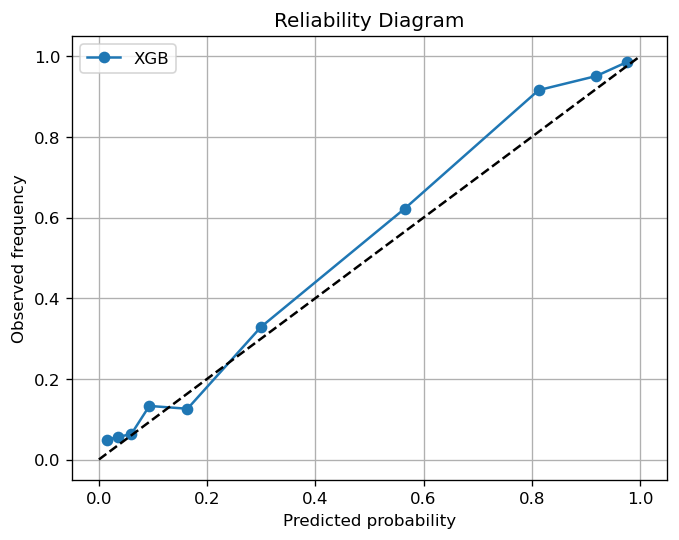

Optimal F1 threshold (uncalibrated): 0.33 (F1=0.8504)


In [38]:
# ==========================================================
# 17. CALIBRATION + THRESHOLD
# ==========================================================
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, y_proba)
print(f"Brier score: {brier:.4f}")

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='XGB')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability Diagram'); plt.legend(); plt.grid(True); plt.show()

# Threshold search
best_f1, best_t = -1, 0.5
for t in np.linspace(0.1, 0.9, 33):
    preds = (y_proba >= t).astype(int)
    f1_t = f1_score(y_test, preds)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t
print(f"Optimal F1 threshold (uncalibrated): {best_t:.2f} (F1={best_f1:.4f})")




t=0.40  Precision=0.8678  Recall=0.8248  F1=0.8458
t=0.50  Precision=0.8912  Recall=0.7851  F1=0.8348
t=0.60  Precision=0.9351  Recall=0.7388  F1=0.8255


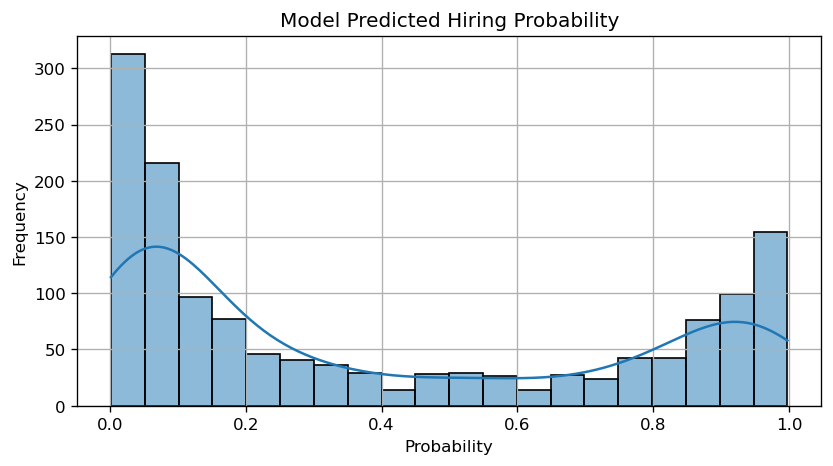

In [39]:
# === Threshold sweep table ===
probs_for_thresh = y_proba  
for t in [0.40, 0.50, 0.60]:
    preds = (probs_for_thresh >= t).astype(int)
    print(f"t={t:.2f}  Precision={precision_score(y_test, preds):.4f}  Recall={recall_score(y_test, preds):.4f}  F1={f1_score(y_test, preds):.4f}")

# === Model probability distribution (test set) ===
plt.figure(figsize=(8,4))
sns.histplot(probs_for_thresh, bins=20, kde=True)
plt.title("Model Predicted Hiring Probability")
plt.xlabel("Probability"); plt.ylabel("Frequency"); plt.grid(True); plt.show()


In [40]:
# === Expected Calibration Error (ECE, simple) ===
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(y_proba, bins) - 1
ece = 0.0
for b in range(len(bins)-1):
    sel = (bin_ids == b)
    if sel.any():
        ece += sel.mean() * abs(y_test[sel].mean() - y_proba[sel].mean())
print(f"ECE (uncalibrated): {ece:.4f}")


ECE (uncalibrated): 0.0416


Inference time for 1430 samples: 0.0152 seconds

XGBoost Performance Metrics
Accuracy:  0.8685
Precision: 0.8912
Recall:    0.7851
F1-score:  0.8348

Confusion Matrix Counts
TP: 475, TN: 767, FP: 58, FN: 130


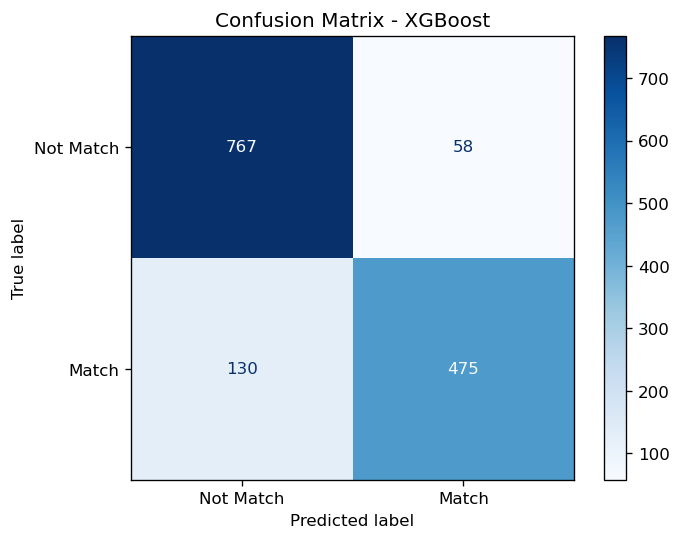


ROC AUC: 0.9277


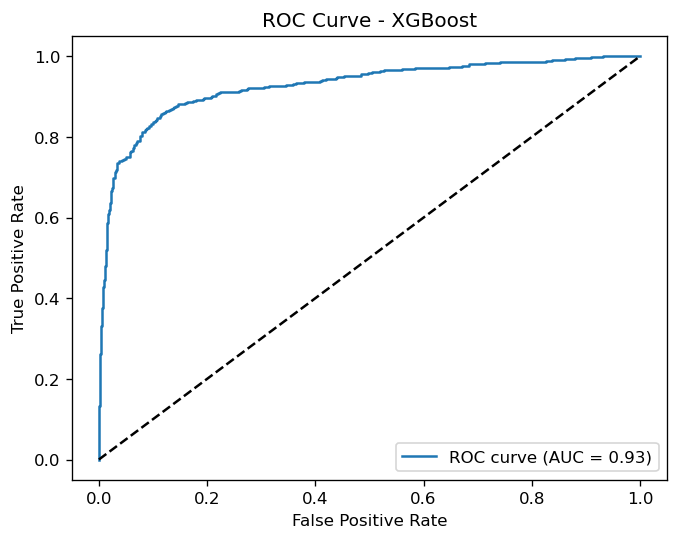


PR AUC: 0.9209


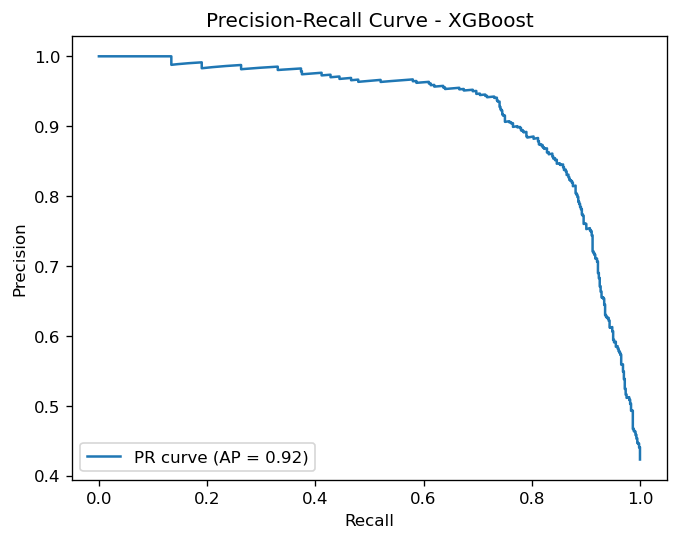


Mean Absolute Error (Hiring Probabilities): 0.1990


In [41]:
# ==========================================================
# 18. RESULTS & DIAGNOSTICS
# ==========================================================
# Timing
import time
start_time = time.time()
_ = best_xgb.predict_proba(X_test)  # warmup
inference_time = time.time() - start_time
print(f"Inference time for {len(X_test)} samples: {inference_time:.4f} seconds")

# Core metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
print("\nXGBoost Performance Metrics")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("\nConfusion Matrix Counts")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Not Match", "Match"], cmap="Blues", ax=ax)
plt.title("Confusion Matrix - XGBoost"); plt.show()

# ROC & PR
fpr, tpr, _ = roc_curve(y_test, y_proba); roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.4f}")
plt.figure(); plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})"); plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve - XGBoost"); plt.legend(loc="lower right"); plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"\nPR AUC: {pr_auc:.4f}")
plt.figure(); plt.plot(recall_vals, precision_vals, label=f"PR curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve - XGBoost"); plt.legend(loc="lower left"); plt.show()

# MAE on probabilities
mae = mean_absolute_error(y_test, y_proba)
print(f"\nMean Absolute Error (Hiring Probabilities): {mae:.4f}")


In [42]:
# MAP on TEST pairs 
test_pairs = match_labeled.loc[X_test.index].copy().assign(proba=y_proba)
test_pairs = test_pairs.dropna(subset=['label', 'job_index'])
test_pairs['label'] = test_pairs['label'].astype(int)

map_scores = []
for job_id, grp in test_pairs.groupby('job_index'):
    labels = grp['label'].values
    scores = grp['proba'].values
    if labels.sum() == 0:  
        continue
    ap = average_precision_score(labels, scores)
    if not np.isnan(ap):
        map_scores.append(ap)
map_value = float(np.mean(map_scores)) if map_scores else 0.0
print(f"\nMean Average Precision (MAP on test, ranked by model proba): {map_value:.4f}")



Mean Average Precision (MAP on test, ranked by model proba): 0.9267


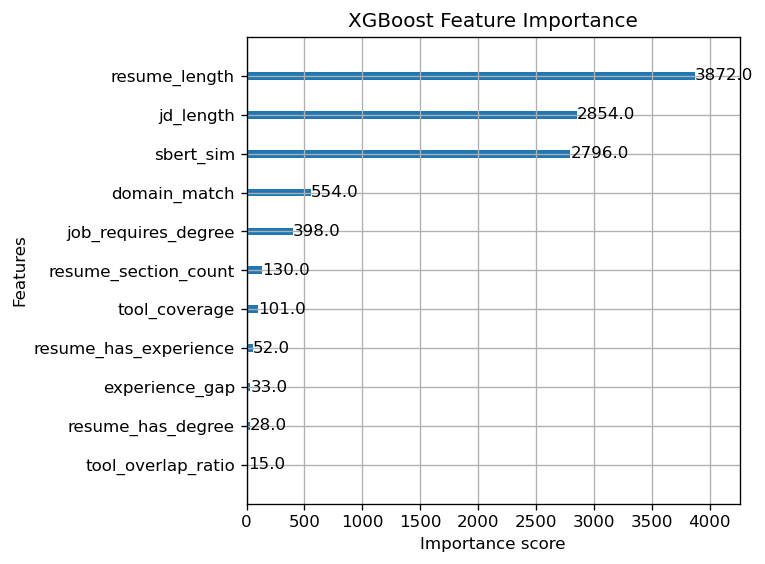

In [43]:
# Feature importance 
plot_importance(best_xgb); plt.title("XGBoost Feature Importance"); plt.tight_layout(); plt.show()


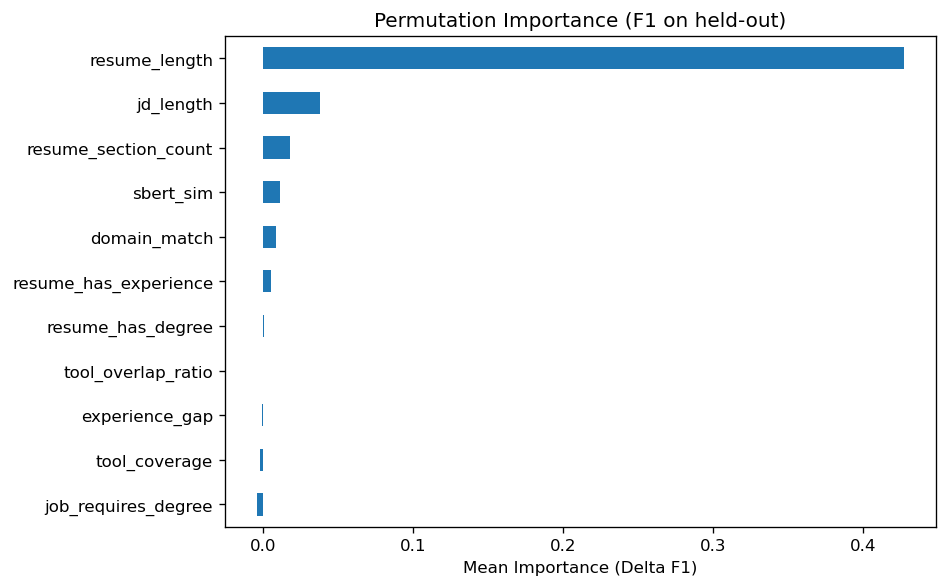

In [44]:
# Permutation importance
perm = permutation_importance(best_xgb, X_test[features], y_test, scoring='f1', n_repeats=10, n_jobs=-1, random_state=42)
perm_importance = pd.Series(perm.importances_mean, index=features).sort_values(ascending=True)
plt.figure(figsize=(8, 5)); perm_importance.plot(kind="barh")
plt.title("Permutation Importance (F1 on held-out)"); plt.xlabel("Mean Importance (Delta F1)"); plt.tight_layout(); plt.show()


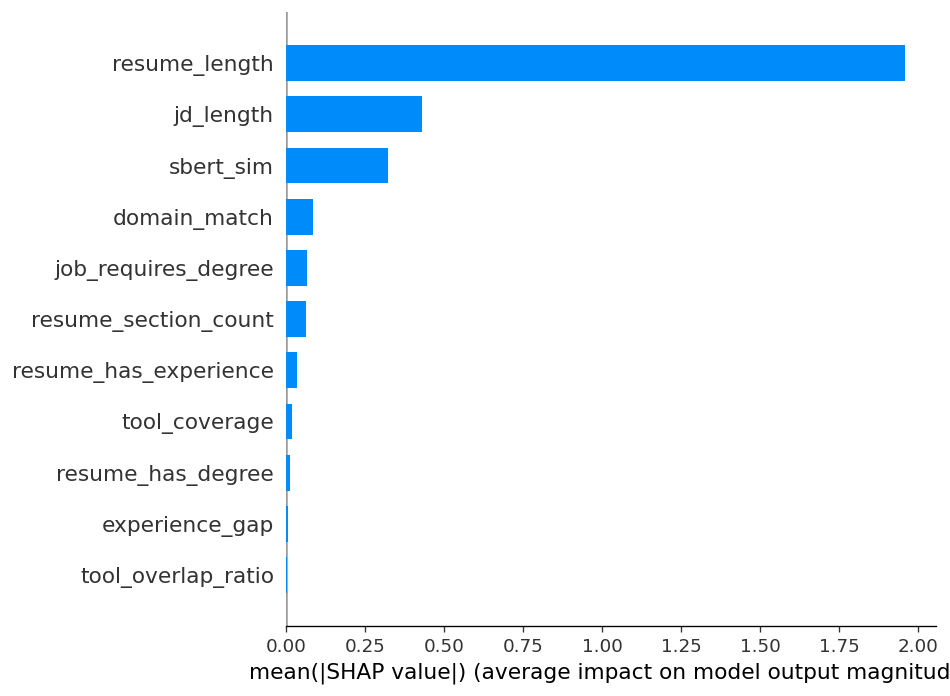

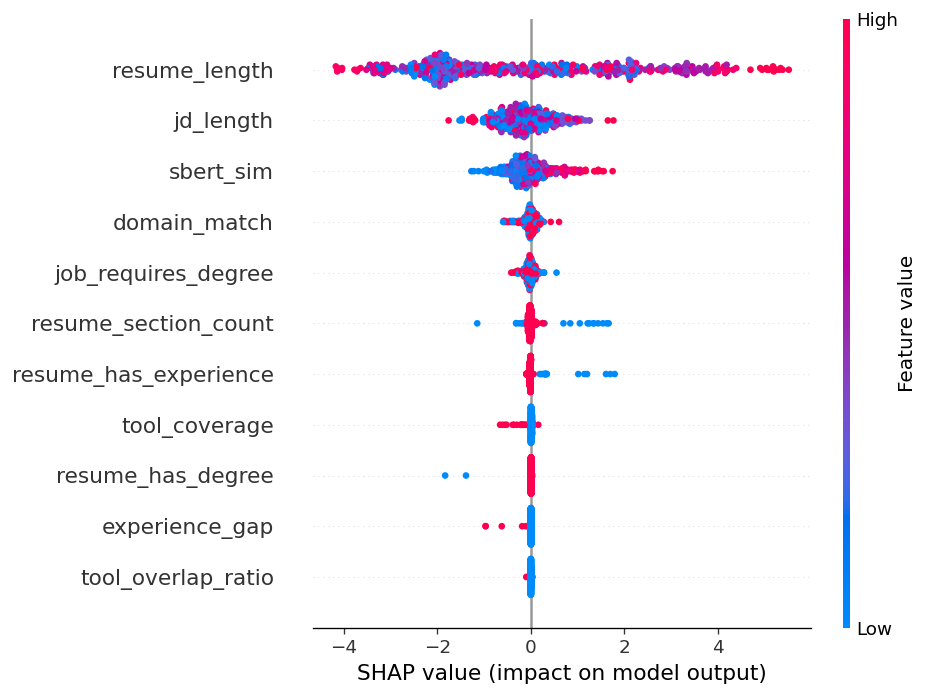

In [45]:
# SHAP 
assert best_xgb.n_features_in_ == len(features) == X_test[features].shape[1], \
    f"Model expects {best_xgb.n_features_in_} features; got {X_test[features].shape[1]}"
shap_explainer = shap.TreeExplainer(best_xgb)
X_shap = X_test[features].sample(n=min(500, len(X_test)), random_state=42)
shap_values_full = shap_explainer.shap_values(X_shap)
shap.summary_plot(shap_values_full, X_shap, plot_type="bar")
shap.summary_plot(shap_values_full, X_shap)

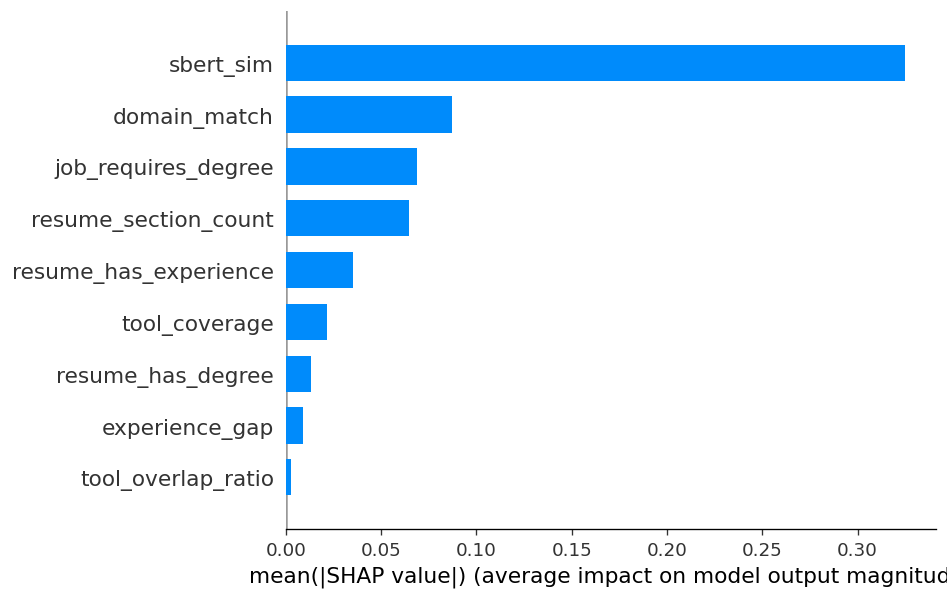

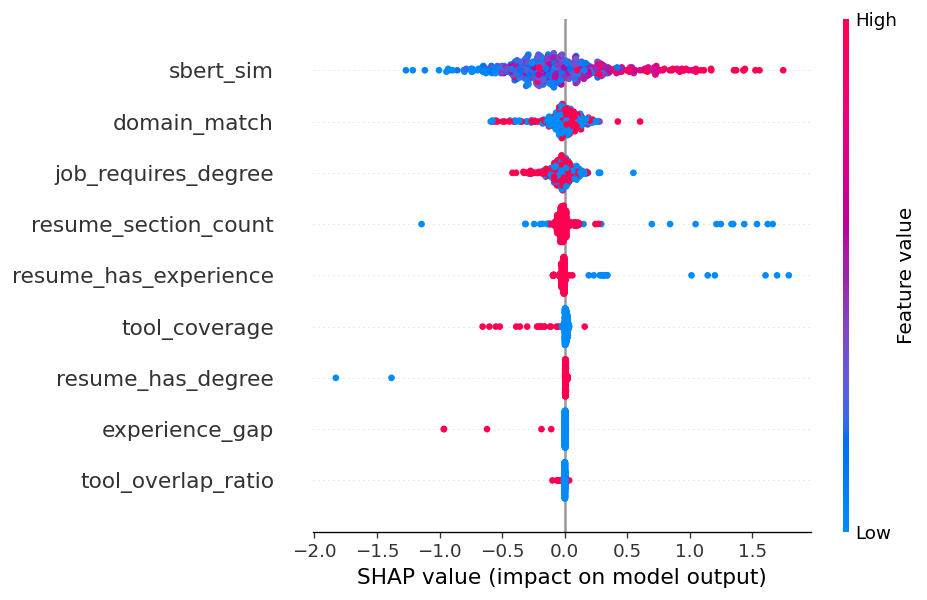

In [46]:
# Sensitivity: exclude length features for display only
EXCLUDE_FEATURES = {"resume_length", "jd_length"}
keep_mask = [c not in EXCLUDE_FEATURES for c in X_shap.columns]
keep_cols = X_shap.columns[keep_mask]
shap.summary_plot(shap_values_full[:, keep_mask], X_shap[keep_cols], plot_type="bar")
shap.summary_plot(shap_values_full[:, keep_mask], X_shap[keep_cols])


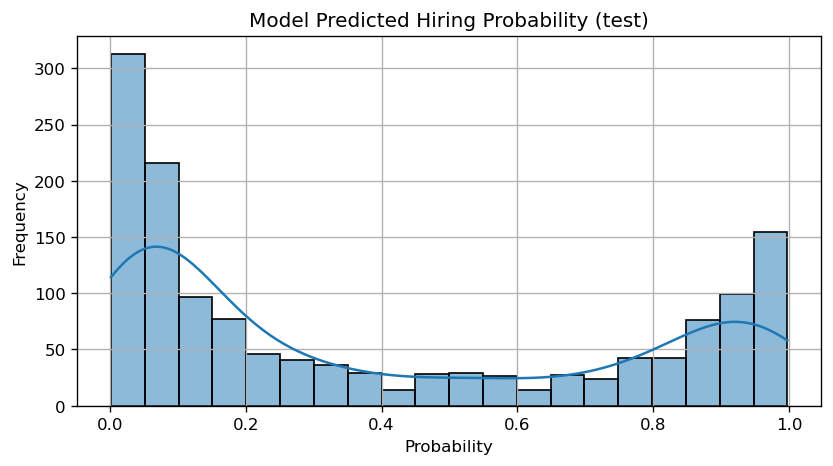

In [47]:
plt.figure(figsize=(8,4))
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Model Predicted Hiring Probability (test)")
plt.xlabel("Probability"); plt.ylabel("Frequency"); plt.grid(True); plt.show()


In [48]:
# === 16b. Grouped Cross-Validation ===
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)
cv_scores = []

# same features & full scaled frame but grouped by job
groups_all = match_labeled.loc[X_scaled.index, 'job_index']

for tr, te in gkf.split(X_scaled[features], y, groups=groups_all):
    mdl = XGBClassifier(**best_xgb.get_xgb_params(), n_estimators=best_xgb.n_estimators)
    mdl.fit(X_scaled.iloc[tr][features], y.iloc[tr])
    preds = mdl.predict(X_scaled.iloc[te][features])
    cv_scores.append(f1_score(y.iloc[te], preds))

print(f"GroupKFold F1 mean={np.mean(cv_scores):.4f}, std={np.std(cv_scores):.4f}")


GroupKFold F1 mean=0.8181, std=0.0107


In [49]:
# === 18b. Length ablation ===
no_len = [f for f in features if f not in {'resume_length','jd_length'}]

mdl_no_len = XGBClassifier(**best_xgb.get_xgb_params(), n_estimators=best_xgb.n_estimators)
mdl_no_len.fit(X_train[no_len], y_train)
y_pred_no = mdl_no_len.predict(X_test[no_len])
f1_no = f1_score(y_test, y_pred_no)
print(f"F1 without length features: {f1_no:.4f}  (Delta={f1_no - f1:.4f} vs full)")


F1 without length features: 0.2898  (Delta=-0.5450 vs full)


In [50]:
# === Category-wise performance on test pairs ===
eval_pairs = match_labeled.loc[X_test.index].copy()
eval_pairs['job_category'] = eval_pairs['job_index'].map(lambda j: job_df.at[j, 'job_category'])
eval_pairs['pred'] = y_pred
eval_pairs['true'] = y_test.values

cat_stats = []
for cat, grp in eval_pairs.groupby('job_category'):
    if len(grp) < 20: 
        continue
    cat_stats.append((
        cat,
        precision_score(grp['true'], grp['pred']),
        recall_score(grp['true'], grp['pred']),
        f1_score(grp['true'], grp['pred']),
        len(grp)
    ))
cat_df = pd.DataFrame(cat_stats, columns=['Category','Precision','Recall','F1','N']).sort_values('F1', ascending=False)
print("\nCategory-wise metrics (test):\n", cat_df.to_string(index=False))



Category-wise metrics (test):
               Category  Precision   Recall       F1   N
  BUSINESS-DEVELOPMENT   0.947368 0.947368 0.947368  37
                   BPO   1.000000 0.875000 0.933333  50
                 SALES   0.961373 0.888889 0.923711 548
             MARKETING   0.888889 0.888889 0.888889  29
            CONSULTANT   0.892473 0.864583 0.878307 213
INFORMATION-TECHNOLOGY   0.800000 0.842105 0.820513  97
               TEACHER   0.818182 0.692308 0.750000  38
          CONSTRUCTION   0.789474 0.625000 0.697674  77
            ACCOUNTANT   0.708333 0.653846 0.680000  63
               FINANCE   0.818182 0.580645 0.679245  68
                  ARTS   0.833333 0.454545 0.588235  28
           ENGINEERING   0.750000 0.444444 0.558140  44
              DESIGNER   1.000000 0.333333 0.500000  37


In [51]:
# === Error reason for FNs and FPs ===
def missing_tools_for_pair(j_idx, r_idx):
    req = set(job_df.at[j_idx, 'required_tools'] or [])
    res = set(resume_df.at[r_idx, 'tools'] or [])
    return sorted(req - res)

eval_pairs['type'] = np.where((eval_pairs['true']==1) & (eval_pairs['pred']==0),'FN',
                       np.where((eval_pairs['true']==0) & (eval_pairs['pred']==1),'FP','OK'))
errs = eval_pairs[eval_pairs['type']!='OK'].copy()

errs['miss_tools'] = errs.apply(lambda row: missing_tools_for_pair(row['job_index'], row['resume_index']), axis=1)
errs['deg_req']    = errs['job_index'].map(lambda j: job_df.at[j,'required_degree'])
errs['deg_has']    = errs['resume_index'].map(lambda r: resume_df.at[r,'degree'])
errs['exp_gap']    = errs.apply(lambda row: max(0, job_df.at[row['job_index'],'required_experience'] - resume_df.at[row['resume_index'],'experience_years']), axis=1)

print("\nTop missing tools among errors:")
from collections import Counter
tool_counter = Counter([t for lst in errs['miss_tools'] for t in lst])
print(tool_counter.most_common(10))

print("\nDegree shortfalls (counts):")
print((errs['deg_req'].fillna('none') + ' vs ' + errs['deg_has'].fillna('none')).value_counts().head(10))

print("\nExperience gap summary (errors):")
print(errs['exp_gap'].describe())



Top missing tools among errors:
[('excel', 7), ('sql', 2), ('azure', 2), ('python', 1)]

Degree shortfalls (counts):
bachelor vs master      59
none vs master          49
master vs master        25
bachelor vs bachelor    22
bachelor vs none        12
none vs bachelor        10
none vs none             5
master vs bachelor       4
master vs none           1
none vs phd              1
Name: count, dtype: int64

Experience gap summary (errors):
count    188.000000
mean       0.026596
std        0.364662
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: exp_gap, dtype: float64


In [52]:
# req vs nice to have
REQ_KEYWORDS  = ['must', 'required', 'requirement', 'mandatory', 'need to', 'need', 'minimum']
NICE_KEYWORDS = ['nice to have', 'preferred', 'bonus', 'plus', 'optional', 'desirable']

def _sentences(text: str):
    if not isinstance(text, str): return []
    return re.split(r'(?<=[\.\?\!])\s+', text.lower())

# Checks nearby sentences for req/nice words 
def _tag_tools_required(job_text: str, tools):
    sents = _sentences(job_text)
    req, nice = set(), set()
    for tool in tools or []:
        t = tool.lower()
        for s in sents:
            if t in s:
                if any(k in s for k in REQ_KEYWORDS):
                    req.add(tool)
                elif any(k in s for k in NICE_KEYWORDS):
                    nice.add(tool)
    return req, nice




In [53]:

# Use extracted signals (degree/experience/tools/soft skills/sections) to form the feedback uses 
def generate_resume_feedback_cached(
    resume_profile,
    job_requirements,
    hiring_prob,
    section_count=3,
    job_text="",
    sbert_sim=None,
    resume_len_words=None,
    jd_len_words=None,
    resume_has_experience=None
):
    
    feedback = []

    # ---- 1) Degree ----
    order = {"phd":3, "master":2, "bachelor":1, None:0}
    req_deg = order.get(job_requirements.get("degree"), 0)
    has_deg = order.get(resume_profile.get("degree"), 0)
    if req_deg > 0:
        if has_deg == 0:
            feedback.append(f"The job requires a {job_requirements['degree']} degree, but your resume does not mention any education.")
        elif has_deg < req_deg:
            feedback.append(f"The job requires a {job_requirements['degree']} degree, but your resume mentions a {resume_profile['degree']} degree.")

    # ---- 2) Experience years ----
    req_exp = int(job_requirements.get("experience_years") or 0)
    has_exp = int(resume_profile.get("experience_years") or 0)
    if req_exp and has_exp < req_exp:
        feedback.append(f"The job requires at least {req_exp} years of experience, but your resume shows ~{has_exp}.")

    # ---- 3) Tools, with required vs nice tagging ----
    job_tools = set(job_requirements.get("tools", []) or [])
    res_tools = set(resume_profile.get("tools", []) or [])
    missing = sorted(job_tools - res_tools)

    REQ_KEYWORDS  = ['must', 'required', 'requirement', 'mandatory', 'need to', 'need', 'minimum']
    NICE_KEYWORDS = ['nice to have', 'preferred', 'bonus', 'plus', 'optional', 'desirable']

    def _sentences(text: str):
        if not isinstance(text, str): return []
        return re.split(r'(?<=[\.\?\!])\s+', text.lower())

    def _tag_tools_required(job_text: str, tools):
        sents = _sentences(job_text)
        req, nice = set(), set()
        for tool in tools or []:
            t = tool.lower()
            for s in sents:
                if t in s:
                    if any(k in s for k in REQ_KEYWORDS):
                        req.add(tool)
                    elif any(k in s for k in NICE_KEYWORDS):
                        nice.add(tool)
        return req, nice

    req_set, nice_set = _tag_tools_required(job_text, job_tools)
    missing_required = sorted(set(missing) & req_set)
    missing_nice     = sorted(set(missing) & nice_set)
    missing_unknown  = sorted(set(missing) - set(missing_required) - set(missing_nice))

    # Good score message
    if hiring_prob >= 95:
        if missing_required:
            feedback.append("Excellent overall fit, but the Job Description lists some **required** skills not shown: " +
                            ", ".join(missing_required) + ". Add them if you have them.")
        maybe = sorted(set(missing_nice) | set(missing_unknown))
        if maybe:
            feedback.append("Excellent fit. Optional skills that could further strengthen your resume: " +
                            ", ".join(maybe) + ".")
        if not (missing_required or missing_nice or missing_unknown) and not feedback:
            feedback.append("Excellent fit. Your resume aligns very closely with the job requirements.")
    # Requirements
    else:
        if missing_required:
            feedback.append("You're missing **required** technical skills: " + ", ".join(missing_required) + ".")
        if missing_nice:
            feedback.append("Nice-to-have skills the Job Description mentions: " + ", ".join(missing_nice) + ".")
        if missing_unknown and not (missing_required or missing_nice):
            feedback.append("The Job Description mentions additional tools you haven't listed: " + ", ".join(missing_unknown) + ".")

    # ---- 4) Soft skills ----
    job_soft = job_requirements.get("soft_skills", []) or []
    res_soft = resume_profile.get("soft_skills", []) or []
    missing_soft = [s for s in job_soft if s not in res_soft]
    if missing_soft and hiring_prob < 95:
        feedback.append("Consider highlighting soft skills valued in the JD: " + ", ".join(sorted(missing_soft)) + ".")

    # ---- 5) Structure / sections ----
    if section_count < 2 and hiring_prob < 95:
        feedback.append("Your resume lacks clear sections like Skills, Education, or Experience. Consider improving structure.")

    # ---- 6) Extra feedback
    if sbert_sim is not None and hiring_prob < 60 and sbert_sim < 0.22:
        feedback.append("Your resume language seems loosely aligned with the JD. Mirror the JD’s key phrases and responsibilities where relevant.")

    
    if resume_has_experience is not None and hiring_prob < 60 and not resume_has_experience:
        feedback.append("Add an Experience section with bullet points and quantified outcomes (e.g., “increased X by Y%”).")

    
    if resume_len_words is not None and hiring_prob < 60 and resume_len_words < 120:
        feedback.append("Your resume looks quite short; add 3–5 impact bullets per role, include tools/skills, and quantify results.")

   
    if hiring_prob < 60 and not job_tools and len([m for m in feedback if "skill" in m or "tool" in m]) == 0:
        feedback.append("The JD doesn’t list specific tools; focus on role-relevant achievements and keywords from the responsibilities section.")

    # ---- 7) Fallback ----
    if not feedback:
        if hiring_prob >= 70:
            feedback.append("Strong fit. Your resume aligns well with the job requirements.")
        else:
            
            feedback.append("Tailor your resume to this JD: echo the role title, key responsibilities, and measurable outcomes to improve alignment.")

    return feedback


In [54]:
def _build_cleaned_resume_text_for_sbert(resume_text: str) -> str:
    secs = extract_sections(resume_text or "")
    combined = (secs.get('education', "") + " " + secs.get('experience', "") + " " + secs.get('skills', "")).strip()
    return clean_text(combined)

def _build_cleaned_jd_text_for_sbert(jd_text: str) -> str:
    req = extract_job_reqs(jd_text or "")
    return clean_text(req)

In [55]:
# Add penalties to lacking requrements, increase/decrease the score based on matches
def postprocess_probability(prob, job_requirements, resume_profile, job_text="", sbert_sim=None):
    
    p = float(prob)

    # ---------- TOOLS ----------
    req_tools = set(job_requirements.get("tools") or [])
    res_tools = set(resume_profile.get("tools") or [])
    inter     = req_tools & res_tools
    coverage  = (len(inter) / max(len(req_tools), 1)) if req_tools else 1.0
    missing_tools = req_tools - res_tools

    # Tag required vs nice
    REQ_KEYWORDS  = ['must', 'required', 'requirement', 'mandatory', 'need to', 'need', 'minimum']
    NICE_KEYWORDS = ['nice to have', 'preferred', 'bonus', 'plus', 'optional', 'desirable']
    def _sents(t): 
        return re.split(r'(?<=[\.\?\!])\s+', (t or "").lower())
    req_set, nice_set = set(), set()
    for tl in req_tools:
        for s in _sents(job_text):
            if tl in s:
                if any(k in s for k in REQ_KEYWORDS): req_set.add(tl)
                elif any(k in s for k in NICE_KEYWORDS): nice_set.add(tl)
    missing_required = (missing_tools & req_set) if req_set else set(missing_tools)
    missing_req_count = len(missing_required)

    
    if req_tools:
        
        p *= (0.40 + 0.60 * (coverage ** 1.35))

        
        p -= 0.06 * missing_req_count

    # Bonus for full tool coverage
    if req_tools and missing_req_count == 0:
        p += 0.07  

    # ---------- DEGREE ----------
    def _degree_order(tag):
        return {"phd": 3, "master": 2, "bachelor": 1, None: 0}.get(tag, 0)

    req_deg = _degree_order(job_requirements.get("degree"))
    has_deg = _degree_order(resume_profile.get("degree"))
    degree_shortfall = 0
    if req_deg > 0:
        if has_deg == 0:
            p -= 0.12; degree_shortfall = 1
        elif has_deg < req_deg:
            p -= 0.10; degree_shortfall = 1
        else:
            p += 0.03  

    # ---------- EXPERIENCE ----------
    req_exp = int(job_requirements.get("experience_years") or 0)
    has_exp = int(resume_profile.get("experience_years") or 0)
    exp_shortfall = 0
    if req_exp and has_exp < req_exp:
        gap = req_exp - has_exp
        p -= min(0.30, 0.06 * gap)  
        exp_shortfall = 1
    elif req_exp and has_exp >= req_exp:
        p += 0.03  

    # ---------- SOFT SKILLS ----------
    job_soft = set(job_requirements.get("soft_skills") or [])
    res_soft = set(resume_profile.get("soft_skills") or [])
    missing_soft = job_soft - res_soft
    if job_soft:
        # Heavier penalty per missing soft skill
        p -= min(0.16, 0.04 * len(missing_soft))
        if not missing_soft:
            p += 0.03  

    # ---------- LOW SEMANTIC ALIGNMENT GUARD ----------
    if sbert_sim is not None and sbert_sim < 0.18:
        p -= 0.05

    # ---------- HARD CAPS by total missing requirements ----------
    total_missing = missing_req_count + len(missing_soft) + degree_shortfall + exp_shortfall
    # Stricter caps to push clearly-below-par profiles down
    if total_missing >= 4:
        p = min(p, 0.55)
    elif total_missing == 3:
        p = min(p, 0.68)
    elif total_missing == 2:
        p = min(p, 0.76)
    elif total_missing == 1:
        p = min(p, 0.85)
    

    # ---------- PERFECT COMPLIANCE BOOST ----------
    if (total_missing == 0) and (req_tools or job_soft or req_deg or req_exp):
        # Only when there were actual requirements to satisfy
        if sbert_sim is None or sbert_sim >= 0.22:
            p = min(0.97, p + 0.08)  

    return float(np.clip(p, 0.0, 1.0))


In [56]:
# === SBERT cosine ===
def sbert_cos_from_texts(jd_text: str, resume_text: str, use_training_clean: bool = True) -> float:
    from sentence_transformers import SentenceTransformer, util as st_util
    sbert = globals().get('sbert_model', None) or SentenceTransformer("all-MiniLM-L6-v2")

    if use_training_clean:
        a_text = _build_cleaned_jd_text_for_sbert(jd_text)
        b_text = _build_cleaned_resume_text_for_sbert(resume_text)
    else:
        a_text = jd_text or ""
        b_text = resume_text or ""

    a = sbert.encode([a_text], convert_to_tensor=True)
    b = sbert.encode([b_text], convert_to_tensor=True)
    return float(st_util.cos_sim(a, b)[0][0].item())


In [57]:
def compute_xgboost_score_from_values(
    job_requirements, resume_profile, job_description_text, resume_text,
    job_category=None, resume_predicted_category=None, model=None, scaler_obj=None
):
    # Load in models
    if model is None:
        model = joblib.load("xgb_model.joblib")
    if scaler_obj is None:
        scaler_obj = joblib.load("xgb_scaler.pkl")

    # Ensure we have structured requirements
    if (not isinstance(job_requirements, dict)) or ('tools' not in job_requirements):
        job_requirements = extract_job_requirements(job_description_text or "")

    jd_len_raw  = len((job_description_text or "").split())
    res_len_raw = len((resume_text or "").split())
    section_count = sum([
        "skill" in (resume_text or "").lower(),
        "education" in (resume_text or "").lower(),
        "experience" in (resume_text or "").lower()
    ])

    # Experience gap
    req_exp  = int(job_requirements.get("experience_years") or 0)
    got_exp  = int(resume_profile.get("experience_years") or 0)
    exp_gap  = max(0, req_exp - got_exp)

    job_tools = job_requirements.get("tools", []) or []
    res_tools = resume_profile.get("tools", []) or []

    
    def _canon_local(c):
        if not isinstance(c, str): return None
        c = c.strip().upper().replace(' ', '-')
        if c == 'DESIGNING': c = 'DESIGNER'
        if c == 'PUBLIC RELATIONS': c = 'PUBLIC-RELATIONS'
        if c == 'DIGITAL MARKETING': c = 'DIGITAL-MEDIA'
        if c == 'DATA SCIENCE': c = 'DATA-SCIENCE'
        return c
    dom_match = int(_canon_local(job_category) == _canon_local(resume_predicted_category)) \
                if (job_category and resume_predicted_category) else 0

    # SBERT similarity 
    sbert_sim_val = sbert_cos_from_texts(
        job_description_text or "",
        resume_text or "",
        use_training_clean=True
    )

    # build the exact same feature vector used for training
    row = {
        'resume_length'        : np.log1p(res_len_raw),
        'jd_length'            : np.log1p(jd_len_raw),
        'resume_has_degree'    : requires_degree(resume_text),
        'job_requires_degree'  : requires_degree(job_description_text),
        'resume_has_experience': mentions_experience(resume_text),
        'tool_coverage'        : tool_coverage_ratio(job_tools, res_tools),
        'resume_section_count' : section_count,
        'domain_match'         : dom_match,
        'experience_gap'       : exp_gap,
        'tool_overlap_ratio'   : tool_overlap_ratio(job_tools, res_tools),
        'sbert_sim'            : sbert_sim_val,
    }

    # Using the saved scaler and then predicting
    df = pd.DataFrame([row], columns=features)      
    df[features] = scaler_obj.transform(df[features])

    
    prob = model.predict_proba(df[features])[:, 1].item()

    prob = postprocess_probability(
        prob,
        job_requirements,
        resume_profile,
        job_text=job_description_text,
        sbert_sim=sbert_sim_val
    )
    
    # ---- Generate feedback for this pair ----
    feedback = generate_resume_feedback_cached(
        resume_profile=resume_profile,
        job_requirements=job_requirements,
        hiring_prob=prob * 100.0,
        section_count=section_count,
        job_text=job_description_text,
        sbert_sim=sbert_sim_val,
        resume_len_words=res_len_raw,
        jd_len_words=jd_len_raw,
        resume_has_experience=mentions_experience(resume_text)
    )

    
    return prob

    


In [58]:
# Read file, extract signals, build features, predict score and generate feedback
def evaluate_resume_against_job(resume_file_path: str,
                                job_description_text: str,
                                use_calibrated: bool = False):
    
    # 1) Read & extract
    resume_text = read_resume_file(resume_file_path)
    jd_text     = job_description_text

    resume_prof = extract_resume_profile(resume_text)
    job_reqs = extract_job_requirements(jd_text)


    # 2) Build feature row 
    job_tools = job_reqs.get('tools', []) or []
    res_tools = resume_prof.get('tools', []) or []
    section_count = sum(k in (resume_text or "").lower() for k in ('skill','education','experience'))
    req_exp = int(job_reqs.get("experience_years") or 0)
    has_exp = int(resume_prof.get("experience_years") or 0)

    # SBERT similarity 
    sbert_sim_val = sbert_cos_from_texts(jd_text, resume_text, use_training_clean=True)

    row = {
        'resume_length'        : np.log1p(len((resume_text or "").split())),
        'jd_length'            : np.log1p(len((jd_text or "").split())),
        'resume_has_degree'    : requires_degree(resume_text),
        'job_requires_degree'  : requires_degree(jd_text),
        'resume_has_experience': mentions_experience(resume_text),
        'tool_coverage'        : tool_coverage_ratio(job_tools, res_tools),
        'resume_section_count' : section_count,
        'domain_match'         : 0,  
        'experience_gap'       : max(0, req_exp - has_exp),
        'tool_overlap_ratio'   : tool_overlap_ratio(job_tools, res_tools),
        'sbert_sim'            : sbert_sim_val
    }

    scaler = joblib.load("xgb_scaler.pkl")
    df = pd.DataFrame([row], columns=features)   
    df[features] = scaler.transform(df[features])

    # 3) Predict 
    model = joblib.load("xgb_model.joblib")
    prob = model.predict_proba(df[features])[:, 1].item()

    # Adjust probability using requirement compliance
    prob_adj = postprocess_probability(
        prob,
        job_reqs,
        resume_prof,
        job_text=jd_text,
        sbert_sim=sbert_sim_val
    )

    
    # 4) generate final, user-facing feedback
    feedback = generate_resume_feedback_cached(
        resume_profile=resume_prof,
        job_requirements=job_reqs,
        hiring_prob=prob_adj * 100.0,
        section_count=section_count,
        job_text=jd_text,
        sbert_sim=sbert_sim_val,
        resume_len_words=len((resume_text or "").split()),
        jd_len_words=len((jd_text or "").split()),
        resume_has_experience=mentions_experience(resume_text)
    )

    return {
        "hiring_probability": round(prob_adj * 100.0, 2),
        "job_requirements": job_reqs,
        "resume_profile": resume_prof,
        "feedback": feedback
    }


In [59]:
def _fmt_list(xs):
    xs = list(xs or [])
    return ", ".join(xs) if xs else "—"

# 1) score, 2) JD requires, 3) resume contains, 4) feedback.
def build_evaluation_report(result: dict) -> str:
   
    prob = result.get("hiring_probability", 0.0)
    reqs = result.get("job_requirements", {}) or {}
    prof = result.get("resume_profile", {}) or {}
    fb   = result.get("feedback", []) or []

    lines = []
    # 1) Score
    lines.append(f"Hiring probability: {prob:.2f} %")

    # 2) JD requires
    lines.append("Job requirements:")
    lines.append(f"   • Degree: {reqs.get('degree') or '—'}")
    lines.append(f"   • Experience: {int(reqs.get('experience_years') or 0)} years")
    lines.append(f"   • Tools: {_fmt_list(reqs.get('tools'))}")
    if reqs.get('soft_skills'):
        lines.append(f"   • Soft skills: {_fmt_list(sorted(reqs.get('soft_skills') or []))}")

    # 3) Resume contains
    lines.append("Resume profile:")
    lines.append(f"   • Degree: {prof.get('degree') or '—'}")
    
    exp = prof.get('experience_years') or 0
    exp_str = f"{exp:.1f}" if isinstance(exp, float) and not exp.is_integer() else f"{int(exp)}"
    lines.append(f"   • Experience: {exp_str} years")
    lines.append(f"   • Tools: {_fmt_list(prof.get('tools'))}")
    if prof.get('soft_skills'):
        lines.append(f"   • Soft skills: {_fmt_list(sorted(prof.get('soft_skills') or []))}")

    # 4) Feedback
    lines.append("Feedback:")
    if fb:
        for msg in fb:
            lines.append(f"- {msg}")
    else:
        lines.append("- (no additional feedback)")

    return "\n".join(lines)


In [60]:
jd_text = """

Graduate/Junior Data Analyst | Fast-Growing SaaS Scale-Up | £30-35K | London (on-site)


About the Company:

Our client is a rapidly growing SaaS scale-up based in London, employing a team of 20 talented professionals who are passionate about transforming industries through software innovation. They specialise in delivering advanced software solutions tailored to the needs of a diverse, expanding client base. Focused on staying ahead of the curve, the company leverages the latest technologies and fosters a culture of continuous improvement, establishing itself as a frontrunner in the SaaS field.


About the Role:

The Data Analyst role presents an exciting opportunity for individuals interested in data management and analysis. In this position, you’ll be responsible for extracting, cleaning, and analysing large datasets to deliver actionable insights that inform business decisions and contribute to the development of top-tier SaaS products. With comprehensive training and development resources, this role allows you to grow your analytical abilities and become proficient with advanced data tools in a fast-paced, agile setting. The ideal candidate will be highly analytical, detail-focused, and eager to drive data-informed decisions.


Responsibilities:

Extracting data from primary and secondary sources, then reorganizing this data in a format that can be easily read by either human or machine.
Using statistical tools to interpret data sets, paying particular attention to trends and patterns that could be valuable for diagnostic and predictive analytics efforts.
Preparing reports for the management stating trends, patterns, and predictions using relevant data.
Collaborating with engineering and product development teams to implement and refine data collection techniques.
Assisting in the design and implementation of databases and data collection systems.
Ensuring data integrity and accuracy in all analytics activities.
Participating in ongoing education and training to stay abreast of industry developments and advancements in data analysis tools and techniques.


Requirements:

Bachelor’s degree in Data Science, Statistics, Mathematics, Computer Science, or a related field is required.
Experience with data models, database design development, data mining, and segmentation techniques.
Proficiency with statistical analysis tools (e.g., SAS, SPSS, R) and programming languages (e.g., SQL, Python)
Strong analytical and problem-solving skills with the ability to collect, organize, analyse, and disseminate significant amounts of information with attention to detail and accuracy.
Effective communication skills and the ability to work collaboratively in a team environment.


Benefits:

A competitive salary range of £30,000 to £35,000.
Extensive career development opportunities, including significant training in advanced data science techniques and tools.
Regular team events, workshops, and networking opportunities.



"""
result = evaluate_resume_against_job("resume(def).pdf", jd_text, use_calibrated=False)
print(build_evaluation_report(result))


Hiring probability: 61.80 %
Job requirements:
   • Degree: bachelor
   • Experience: 0 years
   • Tools: python, r, sas, spss, sql
   • Soft skills: communication, problem-solving
Resume profile:
   • Degree: master
   • Experience: 0 years
   • Tools: excel, hadoop, pandas, power bi, python, pytorch, r, scikit-learn, sql, tableau, tensorflow
Feedback:
- The Job Description mentions additional tools you haven't listed: sas, spss.
- Consider highlighting soft skills valued in the JD: communication, problem-solving.
